In [1]:
%pylab inline

import os
from scipy.interpolate import interp1d as linear
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import derivative
from scipy.stats import norm

from densitycontour import densitycontour

from styles.paper import *
from styles.colors import *
from styles.labels import *

from tools.plots import *
from tools.stats import *

greys_map = cm._generate_cmap(greys_map_name, 256)

Populating the interactive namespace from numpy and matplotlib


In [2]:
change_name = lambda name, strip: "spSpec"+name.lstrip(strip).replace(".log", ".fit")

In [3]:
#load G05 indices from SDSS sample
catalog = genfromtxt("data/sample-obs/catalog.txt", dtype=None, names=True)

g05_table = genfromtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_sample.txt"), dtype=None, names=True)

g05_mod_name = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_mod.log"), dtype=np.str, usecols=(0,))
g05_mindx = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_mod.log"), usecols=(1,2,3,4,5))
g05_mindx = g05_mindx[argsort(g05_mod_name)]

g05_obs_name = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_obs.log"), dtype=np.str, usecols=(0,))
g05_oindx = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_obs.log"), usecols=(1,2,3,4,5))
g05_oindx = g05_oindx[argsort(g05_obs_name)]

g05_ssag = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-sim/G05_indexes_from_ndssag.log"), usecols=(1,2,3,4,5,6,7,8,9,10,11,12))
g05_ssag_dusty = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-sim/G05_indexes_from_ssag.log"), usecols=(1,2,3,4,5,6,7,8,9,10,11,12))

m16_param = genfromtxt(os.path.expandvars("$phd/inputs/real_deal/outs/spec/dynbas_output.log"), dtype=None, names=True)
m16_param["input_file"] = array([change_name(name, "dynbasfit_processed_SPEC_") for name in m16_param["input_file"]])

g05_param = genfromtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/gal2005.txt"), dtype=None, names=True)

cat_in_g05 = array([gal in g05_param["input_file"] for gal in catalog["input_file"]], dtype=np.bool)
m16_in_g05 = array([gal in g05_param["input_file"] for gal in m16_param["input_file"]], dtype=np.bool)

In [4]:
print all(g05_param["input_file"]==catalog["input_file"][cat_in_g05])
print all(m16_param["input_file"][m16_in_g05]==catalog["input_file"][cat_in_g05])
print all(np.sort(g05_mod_name)[m16_in_g05]==catalog["input_file"][cat_in_g05])
print all(np.sort(g05_mod_name)[m16_in_g05]==g05_table["input_file"][m16_in_g05])

True
True
True
True


In [5]:
cat = catalog[cat_in_g05]
m16 = m16_param[m16_in_g05]
g05 = g05_param
obs = np.copy(g05_table[m16_in_g05])
mod = np.copy(g05_table[m16_in_g05])
ssa = np.zeros(g05_ssag.shape[0], dtype=[('D4000', '<f8'),
                                         ('Hbeta', '<f8'),
                                         ('Hdg', '<f8'),
                                         ('Mg2Fe', '<f8'),
                                         ('MgFep', '<f8')]+[('age', '<f8'),
                                                            ('met', '<f8')]+[('umag', '<f8'),
                                                                             ('gmag', '<f8'),
                                                                             ('rmag', '<f8'),
                                                                             ('imag', '<f8'),
                                                                             ('zmag', '<f8')])
ssa_dusty = np.zeros(g05_ssag.shape[0], dtype=[('D4000', '<f8'),
                                         ('Hbeta', '<f8'),
                                         ('Hdg', '<f8'),
                                         ('Mg2Fe', '<f8'),
                                         ('MgFep', '<f8')]+[('age', '<f8'),
                                                            ('met', '<f8')]+[('umag', '<f8'),
                                                                             ('gmag', '<f8'),
                                                                             ('rmag', '<f8'),
                                                                             ('imag', '<f8'),
                                                                             ('zmag', '<f8')])

for i, kw in enumerate("D4000 Hbeta Hdg Mg2Fe MgFep".split()): mod[kw] = g05_mindx[m16_in_g05, i]
for i, kw in enumerate("D4000 Hbeta Hdg Mg2Fe MgFep".split()): obs[kw] = g05_oindx[m16_in_g05, i]
for i, kw in enumerate("D4000 Hbeta Hdg Mg2Fe MgFep age met umag gmag rmag imag zmag".split()): ssa[kw] = g05_ssag[:, i]
for i, kw in enumerate("D4000 Hbeta Hdg Mg2Fe MgFep age met umag gmag rmag imag zmag".split()): ssa_dusty[kw] = g05_ssag_dusty[:, i]

g_z_red = (ssa_dusty["gmag"]-ssa_dusty["zmag"]) - (ssa["gmag"]-ssa["zmag"])
ssa["age"] = log10(ssa["age"])
#ssa["met"] = log10(ssa["met"])
#ssa = ssa[(ssa["met"]>=0.02)&(ssa["met"]<=2.5)]
def log_pdf(x, range):
    a, b = range
    
    if hasattr(x, "__getitem__") and (x[0]==a and x[-1]==b):
        x_ = x
    else:
        x_ = linspace(a, b, 1000)
    
    return (log(x)-log(a))/trapz(log(x_)-log(a), x_)

u = rand(ssa.size)
#ssa = ssa[u<log_pdf(ssa["met"], range=(0.02,2.5))/log_pdf(2.5, range=(0.02,2.5))]

col = cat["u_mag"]-cat["r_mag"]

In [6]:
idir = os.path.expandvars("$phd/notebooks/data/ssp-model-props")
odir = os.path.expandvars("$HOME/Documents/Publications/mejia+2016")

ax_xlabel = {
    "age": r"\bf \log{t/\text{yr}}"
}
ax_ylabels = {
    "D4000": r"\bf D$4000$",
    "Hbeta": r"\bf H$\beta$",
    "Hdg": r"\bf H$\delta_A$+H$\gamma_A$",
    "Mg2Fe": r"\bf [Mg${}_2$Fe]",
    "MgFep": r"\bf [MgFe]'",
    "CaII triplet": r"\bf Ca\textsc{ii} Triplet",
    "u-g": r"\bf $u-g$",
    "u-r": r"\bf $u-r$",
    "g-r": r"\bf $g-r$",
    "g-i": r"\bf $g-i$",
    "g-z": r"\bf $g-z$",
    "r-i": r"\bf $r-i$",
    "r-z": r"\bf $r-z$",
    "i-z": r"\bf $i-z$",
    "M/L_u": r"\bf $M_\star/L_u$",
    "M/L_g": r"\bf $M_\star/L_g$",
    "M/L_r": r"\bf $M_\star/L_r$",
    "M/L_i": r"\bf $M_\star/L_i$",
    "M/L_z": r"\bf $M_\star/L_z$",
    "L_u": r"\bf $L_u$",
    "L_g": r"\bf $L_g$",
    "L_r": r"\bf $L_r$",
    "L_i": r"\bf $L_i$",
    "L_z": r"\bf $L_z$"
}
libraries = {
    "stelib": {
        "m32": r"0.02",
        "m42": r"0.20",
        "m52": r"0.40",
        "m62": r"1.00",
        "m72": r"2.50"
    },
    "miles": {
        "z001": r"0.06",
        "z004": r"0.23",
        "z008": r"0.47",
        "z017": r"1.00",
        "z030": r"1.76",
        "z040": r"2.35"
    }
}
metallicities = {
    r"0.0004": ("m32", "stelib"),
    r"0.004": ("m42", "stelib"),
    r"0.008": ("m52", "stelib"),
    r"0.02": ("m62", "stelib"),
    r"0.05": ("m72", "stelib"),
    r"0.001": ("z001", "miles"),
    r"0.004": ("z004", "miles"),
    r"0.008": ("z008", "miles"),
    r"0.017": ("z017", "miles"),
    r"0.03": ("z030", "miles"),
    r"0.04": ("z040", "miles")
}
indx_maps = {
    "6lsindx_sed": {
        "Mg2": 12,
        "Hbeta": 9,
        "Fe4531": 7,
        "Fe5015": 10,
        "Mgb": 13,
        "Fe5270": 14,
        "Fe5335": 15,
    },
    "7lsindx_sed": {
        "Hdelta_A": 2,
        "Hgamma_A": 3,
        "D4000": 5,
        "CaII8498": 7,
        "CaII8542": 8,
        "CaII8662": 9
    },
    "1ABmag": {
        "u-g": ((1,3), lambda mags: mags[:,0]-mags[:,1]),
        "u-r": ((1,3), lambda mags: mags[:,0]-mags[:,1]),
        "g-r": ((2,3), lambda mags: mags[:,0]-mags[:,1]),
        "g-i": ((2,4), lambda mags: mags[:,0]-mags[:,1]),
        "g-z": ((2,5), lambda mags: mags[:,0]-mags[:,1]),
        "r-i": ((3,4), lambda mags: mags[:,0]-mags[:,1]),
        "r-z": ((3,5), lambda mags: mags[:,0]-mags[:,1]),
        "i-z": ((4,5), lambda mags: mags[:,0]-mags[:,1]),
        "L_u": (1, lambda mag: 10**(-0.4*(mag-5.46))),
        "L_g": (2, lambda mag: 10**(-0.4*(mag-5.21))),
        "L_r": (3, lambda mag: 10**(-0.4*(mag-4.50))),
        "L_i": (4, lambda mag: 10**(-0.4*(mag-4.16))),
        "L_z": (5, lambda mag: 10**(-0.4*(mag-3.99)))
    }
}
file_maps = {
    "tau0": {
        "1color": {
            "age": 0
        },
        "4color": {
            "M": 5
        }
    },
    "tau2": {
        "w_age_rf": {
            "age": 13
        },
        "4color": {
            "M": 5
        }
    },
    "tau5": {
        "w_age_rf": {
            "age": 13
        },
        "4color": {
            "M": 5
        }
    }
}
for modl in file_maps: file_maps[modl].update(indx_maps)

Mg2Fe = lambda Mg2, Fe4531, Fe5015: 0.6*Mg2 + 0.4*log10(abs(Fe4531+Fe5015))
MgFep = lambda Mgb, Fe5270, Fe5335: sqrt(abs(Mgb*(0.72*Fe5270+0.28*Fe5335)))
Hdg = lambda Hdelta, Hgamma: Hdelta + Hgamma
CaII_triplet = lambda CaII8498, CaII8542, CaII8662: CaII8498 + CaII8542 + CaII8662
MLum = lambda M, L: M/L
MLum_err = lambda MLR: MLR*(0.05/1.0857)

def walk_map(library, model):
    return {
        zkw: {
            field: loadtxt("{}/{}/{}_{}.{}".format(idir,library,model,zkw,ftype), usecols=(icol,)) if not hasattr(icol,"__getitem__") else icol[1](loadtxt("{}/{}/{}_{}.{}".format(idir,library,model,zkw,ftype), usecols=((icol[0],) if not hasattr(icol[0],"__getitem__") else icol[0]))) for ftype in file_maps[model] for field, icol in file_maps[model][ftype].iteritems()
        } for zkw in libraries[library]
    }

def add_ingredient(stores, ingredients_list, directions, ingredient_name):
    for store in stores.values():
        store[ingredient_name] = directions(*tuple(store[ingredient] for ingredient in ingredients_list))
    return None

In [7]:
tau0_stelib = walk_map("stelib", "tau0")
tau2_stelib = walk_map("stelib", "tau2")
tau5_stelib = walk_map("stelib", "tau5")

add_ingredient(tau0_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau0_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau0_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau0_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau0_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau0_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau0_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau0_stelib, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau0_stelib, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau0_stelib, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau0_stelib, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau0_stelib, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau0_stelib, ("M/L_z",), MLum_err, "err_M/L_z")

add_ingredient(tau2_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau2_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau2_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau2_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau2_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau2_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau2_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau2_stelib, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau2_stelib, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau2_stelib, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau2_stelib, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau2_stelib, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau2_stelib, ("M/L_z",), MLum_err, "err_M/L_z")

add_ingredient(tau5_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau5_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau5_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau5_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau5_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau5_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau5_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau5_stelib, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau5_stelib, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau5_stelib, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau5_stelib, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau5_stelib, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau5_stelib, ("M/L_z",), MLum_err, "err_M/L_z")

In [8]:
tau0_miles = walk_map("miles", "tau0")
tau2_miles = walk_map("miles", "tau2")
tau5_miles = walk_map("miles", "tau5")

add_ingredient(tau0_miles, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau0_miles, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau0_miles, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau0_miles, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau0_miles, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau0_miles, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau0_miles, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau0_miles, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau0_miles, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau0_miles, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau0_miles, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau0_miles, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau0_miles, ("M/L_z",), MLum_err, "err_M/L_z")

add_ingredient(tau2_miles, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau2_miles, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau2_miles, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau2_miles, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau2_miles, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau2_miles, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau2_miles, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau2_miles, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau2_miles, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau2_miles, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau2_miles, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau2_miles, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau2_miles, ("M/L_z",), MLum_err, "err_M/L_z")

add_ingredient(tau5_miles, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau5_miles, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau5_miles, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau5_miles, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau5_miles, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau5_miles, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau5_miles, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau5_miles, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau5_miles, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau5_miles, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau5_miles, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau5_miles, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau5_miles, ("M/L_z",), MLum_err, "err_M/L_z")

(array([ 0.72580645,  0.84677419,  0.72580645,  0.68548387,  0.16129032,
         0.28225806,  0.04032258,  0.        ,  0.04032258,  0.52419355]),
 array([ 0.02 ,  0.268,  0.516,  0.764,  1.012,  1.26 ,  1.508,  1.756,
         2.004,  2.252,  2.5  ]),
 <a list of 1 Patch objects>)

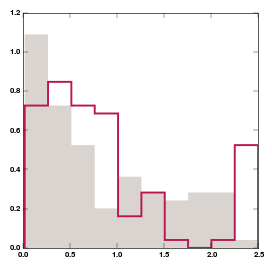

In [ ]:
properties = ["D4000", "Hbeta", "Hdg", "Mg2Fe", "MgFep"]
def gaussian(x, std):
    return 1.0/sqrt(2*pi*std**2) * exp(-0.5*x**2/std**2)
# tomar 10 galaxias para las cuales yo recupero log(t/año)<9.0 (edades que no recupera G05)
# medir los indices de G05 del espectro modelo ajustado a la muestra espectroscopica (revisar que los ajustes son
# buenos alrededor de los indices G05)
# calcular L = exp[-chi^2/2], usando como prior la SSAG
mask = (m16["log_t_L_mod"]<9.0)
NG = 100
likelihood = []
for i in xrange(NG):
    likelihood.append(product([gaussian(mod[mask][prop][i]-ssa[prop], mod[mask][prop+"_err"][i]) for prop in properties], 0))

# calcular la posterior L * prior
nb = 100
ran = (0.02,2.5)
kw = "met"
posterior = zeros(nb)
Z_mode = []
for i in xrange(NG):
    # calcular la joint posterior (el producto de las 10 posteriors)
    pdf, xe = histogram(ssa[kw], nb, range=ran, density=True, weights=likelihood[i])
    x = (xe[1:] + xe[:-1])*0.5
    
    Z_mode.append(x[argmax(pdf)])
    
    posterior += pdf
    
#     pdf = gaussian_filter(pdf, 1.5)
#     N, xe = histogram(ssa[kw], nb, range=ran, density=True)
#     N = gaussian_filter(N, 1.5)
#     figure()
#     plot(x, N/N.max())
#     plot(x, pdf/pdf.max())

Z_mode = array(Z_mode)

hist(10**g05[mask]["log_Z_L_mod"][:NG], range=ran, normed=True, histtype="stepfilled", lw=0, facecolor=samples["light"])
hist(Z_mode, range=ran, normed=True, histtype="step", edgecolor=samples["hot"], lw=1.5)

# ---------------------------------------------------------------------------------------------------------
# mostrar los contornos en estos planos
# mostrar las 10 galaxias en el plano, posicionadas de acuerdo con los parámetros recuperados por G05
# RESULTADOS:
# La distribución posterior se corresponde en edad con la calculada por G05
# En lugar de tratar de recuperar las propiedades de G05 para estas galaxias, podría mostrar solo lo que recupero
# con la SSAG como prior, usando la metodología de G05.
# Si mi hipótesis es correcta, los sesgos que aparecen en las discrepancias con G05 deben aparecer.

In [ ]:
colors = cm.rainbow(linspace(0,1,len(libraries["stelib"])))
properties = ["D4000", "Hbeta", "Hdg", "Mg2Fe", "MgFep", "g-z"]
sigmas = [0.016, 0.352, 0.563, 0.130, 0.052, 0.04]

fig, axs = subplots(3, 2, sharex=True, figsize=(3.3,5))

axs = axs.ravel()
xl = axs[0].set_xlim(8.0,10.15)
axs[0].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
yls = ((0.5,3.0), (0.0,8.0), (-20,25), (-0.05,0.8), (-0.5,5.5), (-0.5,2.5))

for i in xrange(axs.size):
    prop = properties[i]
    
    #axs[i].axvspan(8.5, 9.5, lw=0.7, ls=":", ec=samples["dark"], fc="none")
    axs[i].set_ylabel(ax_ylabels[prop])
    if axs[i].is_last_row(): axs[i].set_xlabel(ax_xlabel["age"])
    axs[i].set_ylim(yls[i])
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
    if axs[i].is_last_col():
        axs[i].tick_params(labelleft=False, labelright=True)
        axs[i].yaxis.set_label_position("right")
    if i==5:
        axs[i].arrow(8.3, 1.0, 0.0, mean(g_z_red), overhang=0, color=samples["dark"])

    #show real life examples from the SDSS
    ppdf = zeros((30,30), dtype=np.float)
    x_, y_, xer_, yer_ = 0.0, 0.0, 0.0, 0.0
    if prop!="g-z":
        for index in xrange(NG):
            x_ += g05[mask][index]["log_t_L_mod"]
            y_ += mod[mask][index][prop]
            xer_ += g05[mask][index]["t_P84p0"] - g05[mask][index]["t_P16p0"]
            yer_ += mod[mask][index]["{}_err".format(prop)]
            
#             axs[i].errorbar(g05[mask][index]["log_t_L_mod"], mod[mask][index][prop], mod[mask][index]["{0}_err".format(prop)], ls="none", mew=1, ecolor=colors[argmin(abs(array(map(eval, sorted(libraries["stelib"].values())))-0.02*10**g05[mask][index]["log_Z_L_mod"]))])
            axs[i].plot(g05[mask][index]["log_t_L_mod"], mod[mask][index][prop], ".", ms=3, mew=0, color=samples["cold"])
            H, xe, ye = histogram2d(ssa["age"], ssa[prop], (30,30), [last(30,xl),last(30,yls[i])], weights=likelihood[index], normed=True)
            ppdf += H
    else:
        for index in xrange(NG):
            g_z = cat["g_mag"][mask][index] - cat["z_mag"][mask][index]
            g_z_err = sqrt(cat["g_err"][mask][index]**2+cat["z_err"][mask][index]**2)
            x_ += g05[mask][index]["log_t_L_mod"]
            y_ += g_z
            xer_ += g05[mask][index]["t_P84p0"] - g05[mask][index]["t_P16p0"]
            yer_ += g_z_err

#             axs[i].errorbar(g05[mask][index]["log_t_L_mod"], g_z, g_z_err, ls="none", mew=1, ecolor=colors[argmin(abs(array(map(eval, sorted(libraries["stelib"].values())))-0.02*10**g05[mask][index]["log_Z_L_mod"]))])
            axs[i].plot(g05[mask][index]["log_t_L_mod"], g_z, ".", ms=3, mew=0, color=samples["cold"])
            H, xe, ye = histogram2d(ssa["age"], ssa["gmag"]-ssa["zmag"], (30,30), [last(30,xl),last(30,yls[i])], weights=likelihood[index], normed=True)
            ppdf += H
    x_, y_, xer_, yer_ = x_/NG, y_/NG, xer_/NG, yer_/NG
    axs[i].errorbar(x_, y_, yer_, xer_, fmt="", ecolor=samples["hot"], elinewidth=0.5, mew=0.5, zorder=9)
#     ppdf = gaussian_filter(ppdf, sigma=1.5)
#     den = axs[i].pcolormesh(xe[:-1], ye[:-1], ppdf.T, cmap=greys_map, vmin=ppdf.min(), vmax=ppdf.max(), edgecolor="face")

    prior, xe, ye = histogram2d(ssa["age"], ssa[prop] if prop!="g-z" else ssa["gmag"]-ssa["zmag"], (30,30), [last(30,xl),last(30,yls[i])], normed=True)
    axs[i].pcolormesh(xe[:-1], ye[:-1], prior.T, cmap=greys_map, vmin=prior.min(), vmax=prior.max(), edgecolor="face")
#     sample_data = densitycontour.ScatterData(ssa["age"], ssa[prop] if prop!="g-z" else ssa["gmag"]-ssa["zmag"])
#     raster = sample_data.rasterize(nbins_x=30, nbins_y=30, clipping=[last(30,xl),last(30,yls[i])])
#     raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
#     contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
#     cont = contours.plot((0.99,0.95,0.68), axes=axs[i], linewidths=0.5, colors=samples["dark"])
#     contours.cilabel(cont, fontsize=5, fmt=r"\bf %.0f", inline=True)

    for j, zkw in enumerate(sorted(libraries["stelib"])):
        if i==1:
            axs[i].text(0.93, 0.9-j*0.07, (r"\bf $Z/\text{Z}_\odot=%s$" if j==0 else r"\bf $%s$")%(libraries["stelib"][zkw]), color=colors[j], fontsize="x-small", ha="right", transform=axs[i].transAxes)
        axs[i].plot(tau0_stelib[zkw]["age"], tau0_stelib[zkw][prop], "--", lw=0.5, color=colors[j])
        axs[i].plot(tau5_stelib[zkw]["age"], tau5_stelib[zkw][prop], "-", lw=0.5, color=colors[j])
#         axs[i].fill_between(tau0_stelib[zkw]["age"], tau0_stelib[zkw][prop]-sigmas[i], tau0_stelib[zkw][prop]+sigmas[i], lw=0, color=samples["light"])
#         axs[i].fill_between(tau5_stelib[zkw]["age"], tau5_stelib[zkw][prop]-sigmas[i], tau5_stelib[zkw][prop]+sigmas[i], lw=0, color=samples["light"])

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.05)

# fig.savefig("{}/g05_indices".format(odir))